# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Arousal Mean Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_arousal_features_mean = pd.read_csv(get_deam_path('processed/features/normalised_essentia_best_arousal_features_mean.csv'))

# drop Unnamed:0 column
df_essentia_best_arousal_features_mean = df_essentia_best_arousal_features_mean[df_essentia_best_arousal_features_mean.columns[1:]]

df_essentia_best_arousal_features_mean

,song_id,lowlevel.average_loudness,lowlevel.barkbands_spread.mean,lowlevel.melbands_crest.mean,lowlevel.melbands_flatness_db.mean,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.melbands_spread.mean,lowlevel.spectral_energy.mean,lowlevel.spectral_entropy.mean,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,2,0.972741,0.252048,0.432744,0.208882,0.023745,0.224209,0.173672,0.054855,0.788542,...,0.023256,0.010375,0.064544,0.026229,0.046262,0.005850,0.00000,0.083526,0.035887,0.012672
1,3,0.583679,0.053319,0.513446,0.442710,0.082083,0.348482,0.026271,0.211289,0.641965,...,0.000000,0.000000,0.038179,0.000000,0.000000,0.000000,0.00000,0.000000,0.023489,0.035942
2,4,0.990960,0.252515,0.387914,0.228709,0.018062,0.213582,0.184795,0.084731,0.759520,...,0.000000,0.001484,0.002937,0.000000,0.049618,0.000000,0.00000,0.000000,0.000000,0.001057
3,5,0.914417,0.141958,0.272308,0.248498,0.016018,0.181322,0.122572,0.041096,0.664296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.049780,0.00000,0.005017,0.127117,0.022199
4,7,0.991187,0.039860,0.537324,0.446834,0.107675,0.349349,0.017550,0.197274,0.628331,...,0.000000,0.000000,0.000000,0.068694,0.000000,0.162351,0.18304,0.125289,0.000000,0.015840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.996544,0.204043,0.168527,0.239557,0.013781,0.186248,0.153273,0.077709,0.752389,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009682,0.021164
1740,1997,0.998184,0.237238,0.280937,0.379660,0.012825,0.189153,0.186735,0.073405,0.729577,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021985,0.00000,0.140613,0.222683,0.275132
1741,1998,0.911413,0.367479,0.235312,0.137918,0.016787,0.199106,0.244384,0.055710,0.882598,...,0.000000,0.017823,0.000000,0.426784,0.000000,0.353219,0.00000,0.000000,0.038728,0.001058
1742,1999,0.974887,0.208690,0.217848,0.192222,0.022245,0.224935,0.136521,0.054033,0.812471,...,0.068617,0.016337,0.336617,0.005006,0.185430,0.054229,0.00000,0.468710,0.100968,0.176720


In [4]:
df_essentia_best_arousal_features_mean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 305 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    song_id                                  int64  
 1    lowlevel.average_loudness                float64
 2    lowlevel.barkbands_spread.mean           float64
 3    lowlevel.melbands_crest.mean             float64
 4    lowlevel.melbands_flatness_db.mean       float64
 5    lowlevel.melbands_kurtosis.mean          float64
 6    lowlevel.melbands_skewness.mean          float64
 7    lowlevel.melbands_spread.mean            float64
 8    lowlevel.spectral_energy.mean            float64
 9    lowlevel.spectral_entropy.mean           float64
 10   lowlevel.spectral_flux.mean              float64
 11   lowlevel.spectral_kurtosis.mean          float64
 12   lowlevel.spectral_rolloff.mean           float64
 13   lowlevel.spectral_skewness.mean          float64
 14   rhythm

Join both the featureset and annotation set together

In [5]:
df_essentia_best_arousal_features_mean_whole = pd.merge(df_essentia_best_arousal_features_mean, df_annotations, how='inner', on='song_id')
df_essentia_best_arousal_features_mean_whole = df_essentia_best_arousal_features_mean_whole.drop('song_id', axis=1)
df_essentia_best_arousal_features_mean_whole

,lowlevel.average_loudness,lowlevel.barkbands_spread.mean,lowlevel.melbands_crest.mean,lowlevel.melbands_flatness_db.mean,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.melbands_spread.mean,lowlevel.spectral_energy.mean,lowlevel.spectral_entropy.mean,lowlevel.spectral_flux.mean,...,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23,valence_mean_mapped,arousal_mean_mapped
0,0.972741,0.252048,0.432744,0.208882,0.023745,0.224209,0.173672,0.054855,0.788542,0.200886,...,0.064544,0.026229,0.046262,0.005850,0.00000,0.083526,0.035887,0.012672,-0.475,-0.500
1,0.583679,0.053319,0.513446,0.442710,0.082083,0.348482,0.026271,0.211289,0.641965,0.175158,...,0.038179,0.000000,0.000000,0.000000,0.00000,0.000000,0.023489,0.035942,-0.375,-0.425
2,0.990960,0.252515,0.387914,0.228709,0.018062,0.213582,0.184795,0.084731,0.759520,0.237563,...,0.002937,0.000000,0.049618,0.000000,0.00000,0.000000,0.000000,0.001057,0.175,0.125
3,0.914417,0.141958,0.272308,0.248498,0.016018,0.181322,0.122572,0.041096,0.664296,0.144694,...,0.000000,0.000000,0.000000,0.049780,0.00000,0.005017,0.127117,0.022199,-0.150,0.075
4,0.991187,0.039860,0.537324,0.446834,0.107675,0.349349,0.017550,0.197274,0.628331,0.232717,...,0.000000,0.068694,0.000000,0.162351,0.18304,0.125289,0.000000,0.015840,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.204043,0.168527,0.239557,0.013781,0.186248,0.153273,0.077709,0.752389,0.283839,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009682,0.021164,-0.275,0.225
1740,0.998184,0.237238,0.280937,0.379660,0.012825,0.189153,0.186735,0.073405,0.729577,0.252935,...,0.000000,0.000000,0.000000,0.021985,0.00000,0.140613,0.222683,0.275132,0.075,-0.275
1741,0.911413,0.367479,0.235312,0.137918,0.016787,0.199106,0.244384,0.055710,0.882598,0.244576,...,0.000000,0.426784,0.000000,0.353219,0.00000,0.000000,0.038728,0.001058,0.350,0.300
1742,0.974887,0.208690,0.217848,0.192222,0.022245,0.224935,0.136521,0.054033,0.812471,0.243034,...,0.336617,0.005006,0.185430,0.054229,0.00000,0.468710,0.100968,0.176720,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_arousal_features_mean.drop('song_id', axis=1)
features

,lowlevel.average_loudness,lowlevel.barkbands_spread.mean,lowlevel.melbands_crest.mean,lowlevel.melbands_flatness_db.mean,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.melbands_spread.mean,lowlevel.spectral_energy.mean,lowlevel.spectral_entropy.mean,lowlevel.spectral_flux.mean,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,0.972741,0.252048,0.432744,0.208882,0.023745,0.224209,0.173672,0.054855,0.788542,0.200886,...,0.023256,0.010375,0.064544,0.026229,0.046262,0.005850,0.00000,0.083526,0.035887,0.012672
1,0.583679,0.053319,0.513446,0.442710,0.082083,0.348482,0.026271,0.211289,0.641965,0.175158,...,0.000000,0.000000,0.038179,0.000000,0.000000,0.000000,0.00000,0.000000,0.023489,0.035942
2,0.990960,0.252515,0.387914,0.228709,0.018062,0.213582,0.184795,0.084731,0.759520,0.237563,...,0.000000,0.001484,0.002937,0.000000,0.049618,0.000000,0.00000,0.000000,0.000000,0.001057
3,0.914417,0.141958,0.272308,0.248498,0.016018,0.181322,0.122572,0.041096,0.664296,0.144694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.049780,0.00000,0.005017,0.127117,0.022199
4,0.991187,0.039860,0.537324,0.446834,0.107675,0.349349,0.017550,0.197274,0.628331,0.232717,...,0.000000,0.000000,0.000000,0.068694,0.000000,0.162351,0.18304,0.125289,0.000000,0.015840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.204043,0.168527,0.239557,0.013781,0.186248,0.153273,0.077709,0.752389,0.283839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.009682,0.021164
1740,0.998184,0.237238,0.280937,0.379660,0.012825,0.189153,0.186735,0.073405,0.729577,0.252935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021985,0.00000,0.140613,0.222683,0.275132
1741,0.911413,0.367479,0.235312,0.137918,0.016787,0.199106,0.244384,0.055710,0.882598,0.244576,...,0.000000,0.017823,0.000000,0.426784,0.000000,0.353219,0.00000,0.000000,0.038728,0.001058
1742,0.974887,0.208690,0.217848,0.192222,0.022245,0.224935,0.136521,0.054033,0.812471,0.243034,...,0.068617,0.016337,0.336617,0.005006,0.185430,0.054229,0.00000,0.468710,0.100968,0.176720


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [36]:
num_epochs = 237

Set a random seed to ensure consistent initial weights of the neural network

In [37]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [39]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 304])


Training loop

In [40]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [41]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5861411440141812
Epoch 2, Loss: 0.5833271372556862
Epoch 3, Loss: 0.5807286990952142
Epoch 4, Loss: 0.5783008874930904
Epoch 5, Loss: 0.576069787243309
Epoch 6, Loss: 0.5739685084230866
Epoch 7, Loss: 0.5719792557619445
Epoch 8, Loss: 0.5701032280723985
Epoch 9, Loss: 0.5683424117975059
Epoch 10, Loss: 0.5667222029688849
Epoch 11, Loss: 0.5652293112105532
Epoch 12, Loss: 0.5638525384493841
Epoch 13, Loss: 0.5625929755618895
Epoch 14, Loss: 0.5614666453957053
Epoch 15, Loss: 0.5604640620396887
Epoch 16, Loss: 0.559636749531073
Epoch 17, Loss: 0.5589084139113625
Epoch 18, Loss: 0.5583043716045648
Epoch 19, Loss: 0.5578044837354285
Epoch 20, Loss: 0.5573913330607448
Epoch 21, Loss: 0.5570604849014634
Epoch 22, Loss: 0.5568063322002479
Epoch 23, Loss: 0.5566252589196254
Epoch 24, Loss: 0.5565061172464457
Epoch 25, Loss: 0.5564255951601211
Epoch 26, Loss: 0.5563788082701243
Epoch 27, Loss: 0.5563585336220127
Epoch 28, Loss: 0.5563590692893251
Epoch 29, Loss: 0.5563738535035

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [42]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 304])


Generating scores

In [45]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [46]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.22400933046068328
Valence RMSE: 0.21061467239993442
Arousal RMSE: 0.23664703682225877
Test R^2 score: tensor([0.4624, 0.4455], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-3.2518, -3.3857], dtype=torch.float64)
Test R^2 score (overall): 0.4539534604397488


In [21]:
torch.save(model.state_dict(), '../../models/deam_feedforward_nn_essentia_best_arousal_mean_normalised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [23]:
test_pred

tensor([[ 1.7016e-01,  1.7525e-01],
        [-2.1732e-01, -2.6248e-01],
        [ 2.4173e-01,  2.4859e-01],
        [-1.2790e-01, -1.6138e-01],
        [-9.6930e-02, -1.3003e-01],
        [-2.4475e-01, -3.0352e-01],
        [-4.0106e-01, -4.7610e-01],
        [ 2.0528e-01,  2.1400e-01],
        [-3.2591e-01, -3.9277e-01],
        [ 2.3364e-01,  2.4110e-01],
        [ 1.9111e-01,  1.9530e-01],
        [-2.2192e-01, -2.7143e-01],
        [-3.0210e-01, -3.7030e-01],
        [ 3.0574e-01,  3.1104e-01],
        [ 7.4247e-02,  6.4801e-02],
        [-1.4272e-01, -1.8135e-01],
        [-3.9147e-01, -4.6387e-01],
        [ 2.2883e-02,  2.3954e-03],
        [ 2.0931e-01,  2.1364e-01],
        [-3.2889e-01, -4.0116e-01],
        [-2.5528e-01, -3.1755e-01],
        [-2.9577e-01, -3.6999e-01],
        [-3.0680e-01, -3.7205e-01],
        [ 1.2288e-01,  1.1709e-01],
        [ 2.2400e-01,  2.2964e-01],
        [ 2.3418e-01,  2.4275e-01],
        [ 2.8343e-01,  2.9034e-01],
        [ 7.1786e-02,  6.316

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.4565, 0.4341], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5861411440141812
Training completed.
Training completed.
Testing model...
Test RMSE: 0.33526133435639127
Valence RMSE: 0.305035303181402
Arousal RMSE: 0.36297904683588295
Test Adjusted R^2 score: tensor([-7.9185, -9.3181], dtype=torch.float64)
Test R^2 score: -0.21610723293372303
Num of epochs: 2
Epoch 1, Loss: 0.5861411440141812
Epoch 2, Loss: 0.5833271372556862
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3322186998297386
Valence RMSE: 0.3026765647420014
Arousal RMSE: 0.3593402651931801
Test Adjusted R^2 score: tensor([-7.7811, -9.1122], dtype=torch.float64)
Test R^2 score: -0.19440874534779606
Num of epochs: 3
Epoch 1, Loss: 0.5861411440141812
Epoch 2, Loss: 0.5833271372556862
Epoch 3, Loss: 0.5807286990952142
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3293921585935423
Valence RMSE: 0.3005107872845336
Arousal RMSE: 0.35593771226361565
Test Adjusted R^2 score: tensor([-7.6559, -8.9216], dtype=torch.

### Plot the graph to visualise the relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

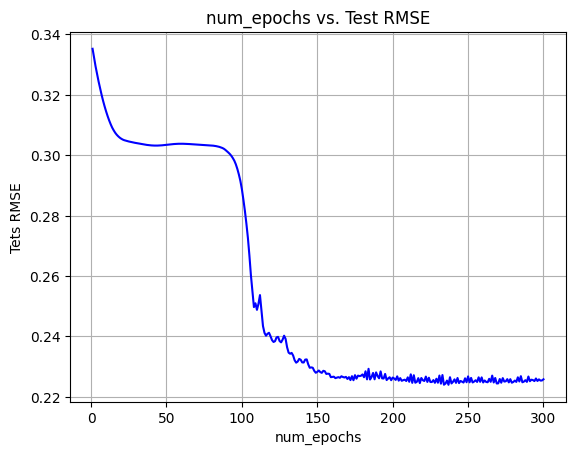

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.22400933046068328
Corresponding R^2 SCore: 0.4539534604397488
Corresponding num_epochs: 237


#### Test R^2 Score vs. num_epochs

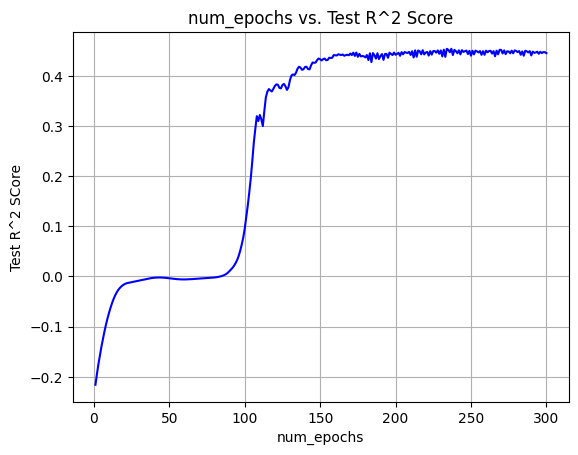

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.4539534604397488
Corresponding RMSE: 0.22400933046068328
Corresponding num_epochs: 237


#### Test Adjusted R^2 SCore (Valence) vs. num_epochs

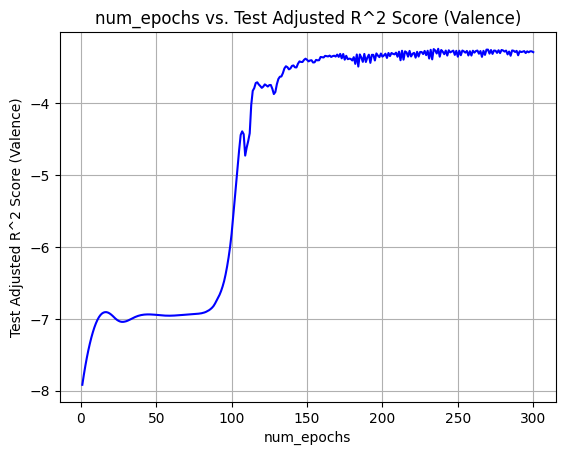

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -3.251776783237223
Corresponding RMSE: 0.22400933046068328
Corresponding num_epochs: 237


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

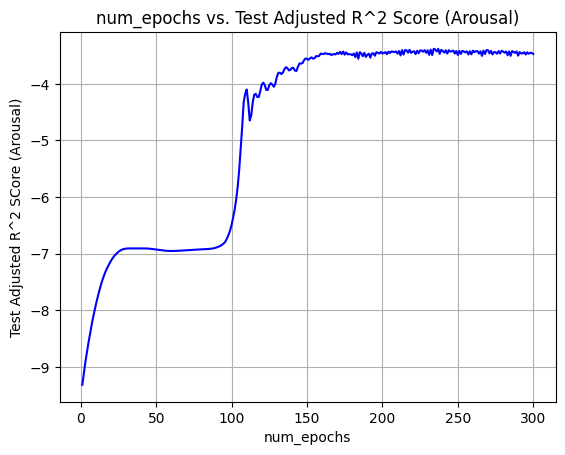

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -3.383463910985882
Corresponding RMSE: 0.2240299511206563
Corresponding num_epochs: 234
